# 2 Modeling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
import math
import pickle 
from sklearn.metrics import mean_absolute_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, RepeatVector, Conv1D, Bidirectional
from helpers import *

# ignore warinings
import warnings
warnings.simplefilter("ignore")

In [2]:
train_dataset = pd.read_csv("./data_preprocessed/train_dataset.csv", index_col=0)
val_dataset = pd.read_csv("./data_preprocessed/val_dataset.csv", index_col=0)
test_dataset = pd.read_csv("./data_preprocessed/test_dataset.csv", index_col=0)

In [3]:
train_dataset.head()

,timiestamp_1,timiestamp_2,timiestamp_3,timiestamp_4,timiestamp_5,timiestamp_6,timiestamp_7,timiestamp_8,timiestamp_9,timiestamp_10,...,timiestamp_132,timiestamp_133,timiestamp_134,timiestamp_135,timiestamp_136,timiestamp_137,timiestamp_138,timiestamp_139,timiestamp_140,label
1603,0.245897,-2.381731,-3.379114,-4.150560,-4.362152,-3.604735,-2.203830,-1.692911,-1.411593,-0.453160,...,0.801240,0.956382,1.052721,1.283904,1.140007,1.142146,0.833684,1.462835,1.532836,1
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,1
2553,0.070699,-2.856309,-4.265050,-4.404080,-4.180707,-3.840098,-2.526704,-1.319836,-1.181694,-0.682616,...,1.168188,1.352643,1.585120,1.585385,1.309638,1.017802,0.896873,1.368133,-0.049731,1
269,-1.537689,-2.534511,-4.240574,-5.250626,-4.853930,-4.223230,-3.200279,-2.332330,-1.817484,-1.083945,...,-0.032903,0.299982,0.707729,0.908099,1.004647,0.855263,0.383952,0.890997,0.461981,1
286,-0.296967,-2.149871,-3.835708,-4.670072,-4.334111,-3.239545,-2.080338,-1.665445,-1.266009,-0.374374,...,0.800871,1.086116,1.090475,0.898527,0.860276,1.536581,1.852604,0.618098,-2.105530,1


In [4]:
X_train = np.array(train_dataset.drop(columns=['label']))
print(X_train.shape)

(2481, 140)


In [5]:
X_val, y_val = np.array(val_dataset.drop(columns=['label'])), np.array(val_dataset['label'])
X_test, y_test = np.array(test_dataset.drop(columns=['label'])), np.array(test_dataset['label'])

print(X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(438, 140) (438,) (438, 140) (438,)


### Reshape feature set to desire format for LSTM (3d array)

In [6]:
# reshape to [num samples, num timesteps, num features]
X_train_3d = X_train.reshape(*X_train.shape,1)
X_val_3d = X_val.reshape(*X_val.shape,1)
X_test_3d = X_test.reshape(*X_test.shape,1)

print(X_train_3d.shape, X_val_3d.shape, X_test_3d.shape)

(2481, 140, 1) (438, 140, 1) (438, 140, 1)


Note that the heartbeat records are in the range of about -7 to 7. In this case, data scalling is not necessary - I did not notice any improvement in models performance after data scalling.

In [7]:
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=0,
    verbose=1,
    patience=20,
    mode='min',
    baseline=None,
    restore_best_weights=True)

EPOCHS = 200
BATCH_SIZE = 32

# placeholder of predition metrics
results = Metrics()

### LSTM AutoEncoder

In [ ]:
# Build model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_3d.shape[1:]) ) )
model.add(RepeatVector(X_train.shape[1]) )
model.add(LSTM(64, return_sequences=True) )
model.add(TimeDistributed(Dense(1) ) )
model.compile(loss='mae', optimizer='adam')
model.summary()

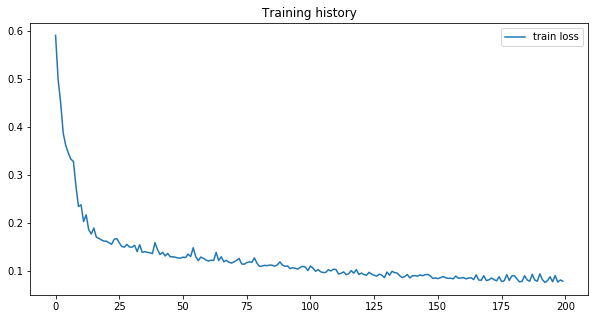

In [25]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING]);

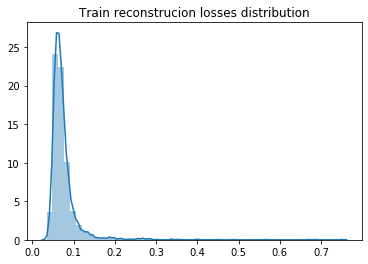

In [26]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True);

In [27]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.0995 Validation Accuracy: 0.9521
Perentile:91 Threshold: 0.1029 Validation Accuracy: 0.9543
Perentile:92 Threshold: 0.1065 Validation Accuracy: 0.9566
Perentile:93 Threshold: 0.1104 Validation Accuracy: 0.9589
Perentile:94 Threshold: 0.1161 Validation Accuracy: 0.9635
Perentile:95 Threshold: 0.1241 Validation Accuracy: 0.9726
Perentile:96 Threshold: 0.134 Validation Accuracy: 0.9795
Perentile:97 Threshold: 0.1478 Validation Accuracy: 0.9817
Perentile:98 Threshold: 0.1863 Validation Accuracy: 0.984
Perentile:99 Threshold: 0.2577 Validation Accuracy: 0.9064
-----------------------------------------------------------------
Best validation accuracy: 0.984 for threshold: 0.1863


In [28]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score)

Test accuracy score: 0.9549
Test precision score: 0.9617
Test recall score: 0.9685
Test f1 score: 0.9551


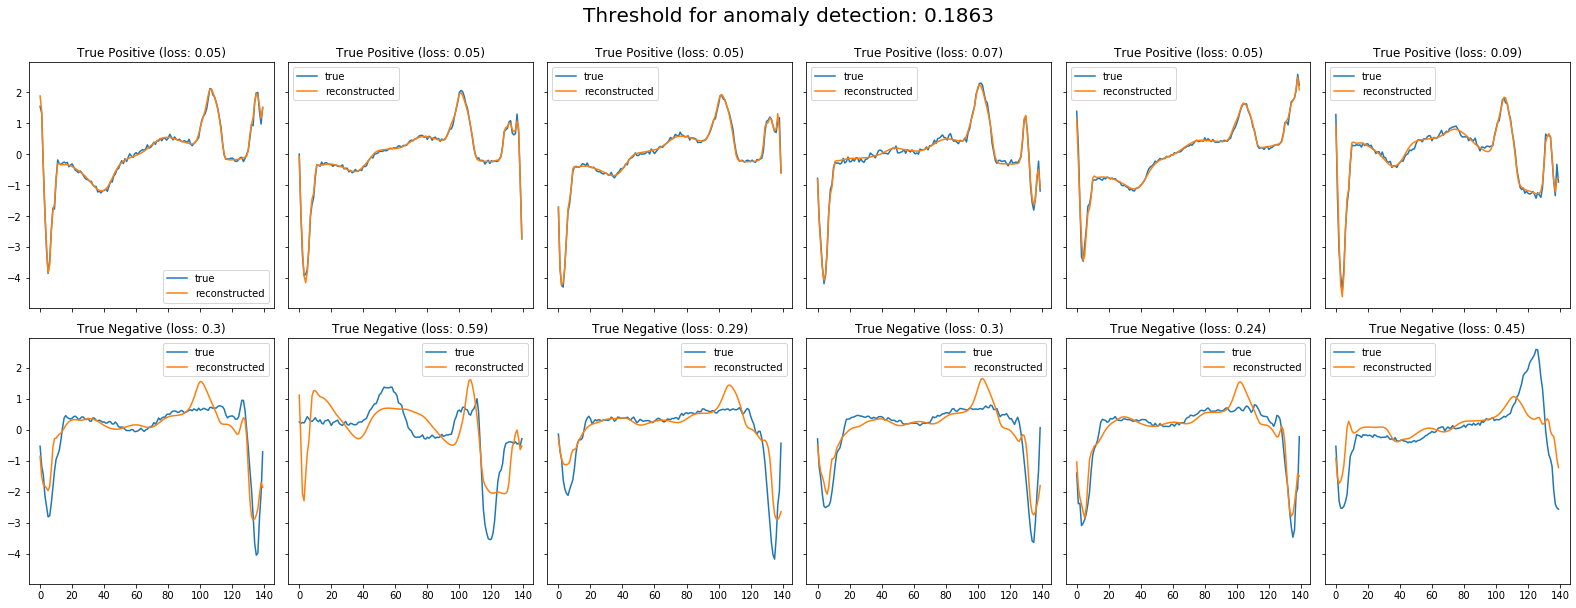

In [29]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

As you can see, LSTM AutoEncoder learned some pattern from training data (an additional peak at the end of the sequence) and tries to recreate it in each sequence - it's easy to see on the anomaly plots.

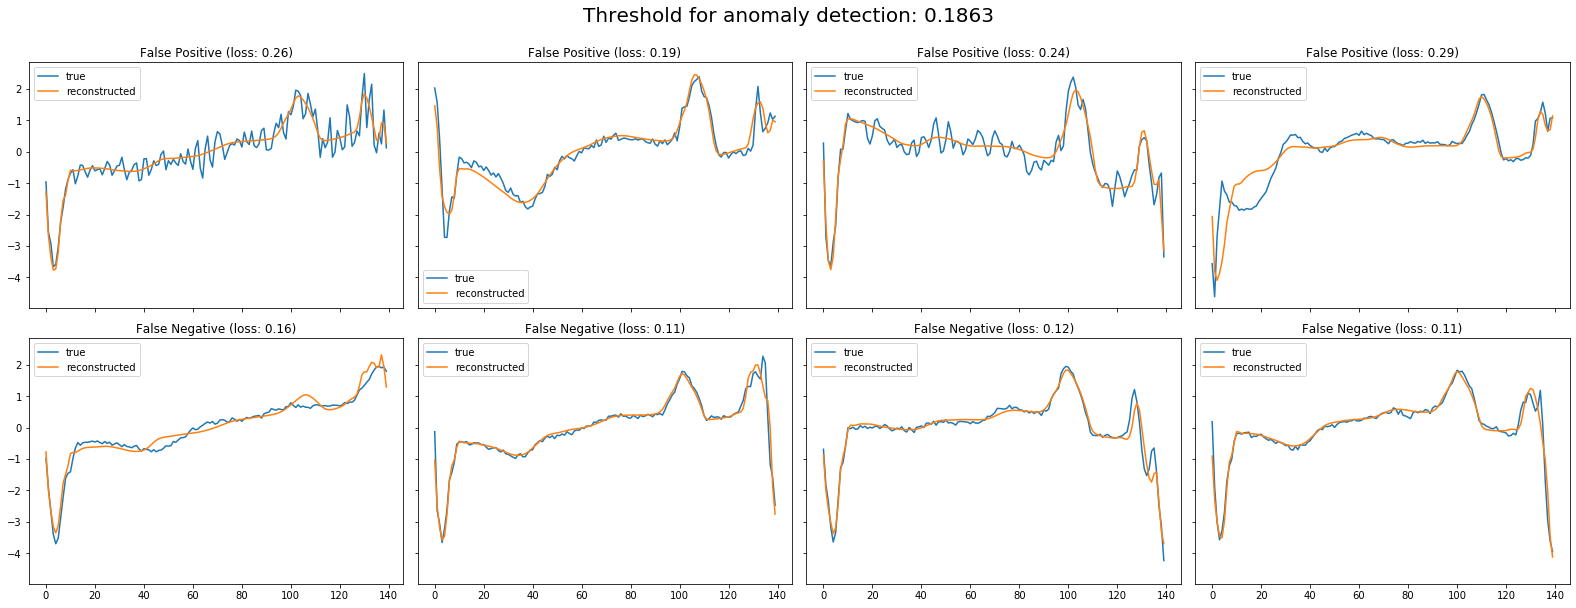

In [30]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

In [31]:
model.save('./models/LSTM_AutoEncoder.h5')

### Stacked LSTM AutoEncoder

In [ ]:
# Build model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_3d.shape[1:]), return_sequences=True))
model.add(LSTM(64))
model.add(RepeatVector(X_train_3d.shape[1]))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mae', optimizer='adam')
model.summary()

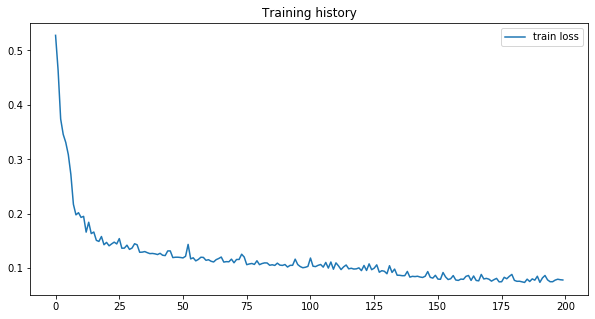

In [33]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING]);

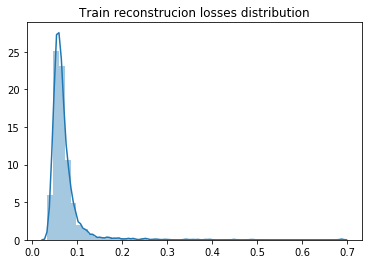

In [34]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True);

In [35]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.0943 Validation Accuracy: 0.9406
Perentile:91 Threshold: 0.0964 Validation Accuracy: 0.9452
Perentile:92 Threshold: 0.1017 Validation Accuracy: 0.9521
Perentile:93 Threshold: 0.1053 Validation Accuracy: 0.9543
Perentile:94 Threshold: 0.11 Validation Accuracy: 0.9589
Perentile:95 Threshold: 0.1172 Validation Accuracy: 0.968
Perentile:96 Threshold: 0.1244 Validation Accuracy: 0.9726
Perentile:97 Threshold: 0.1385 Validation Accuracy: 0.9726
Perentile:98 Threshold: 0.17 Validation Accuracy: 0.9817
Perentile:99 Threshold: 0.2259 Validation Accuracy: 0.9772
-----------------------------------------------------------------
Best validation accuracy: 0.9817 for threshold: 0.17


In [36]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('Stacked LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score)

Test accuracy score: 0.9895
Test precision score: 0.9817
Test recall score: 0.9773
Test f1 score: 0.9795


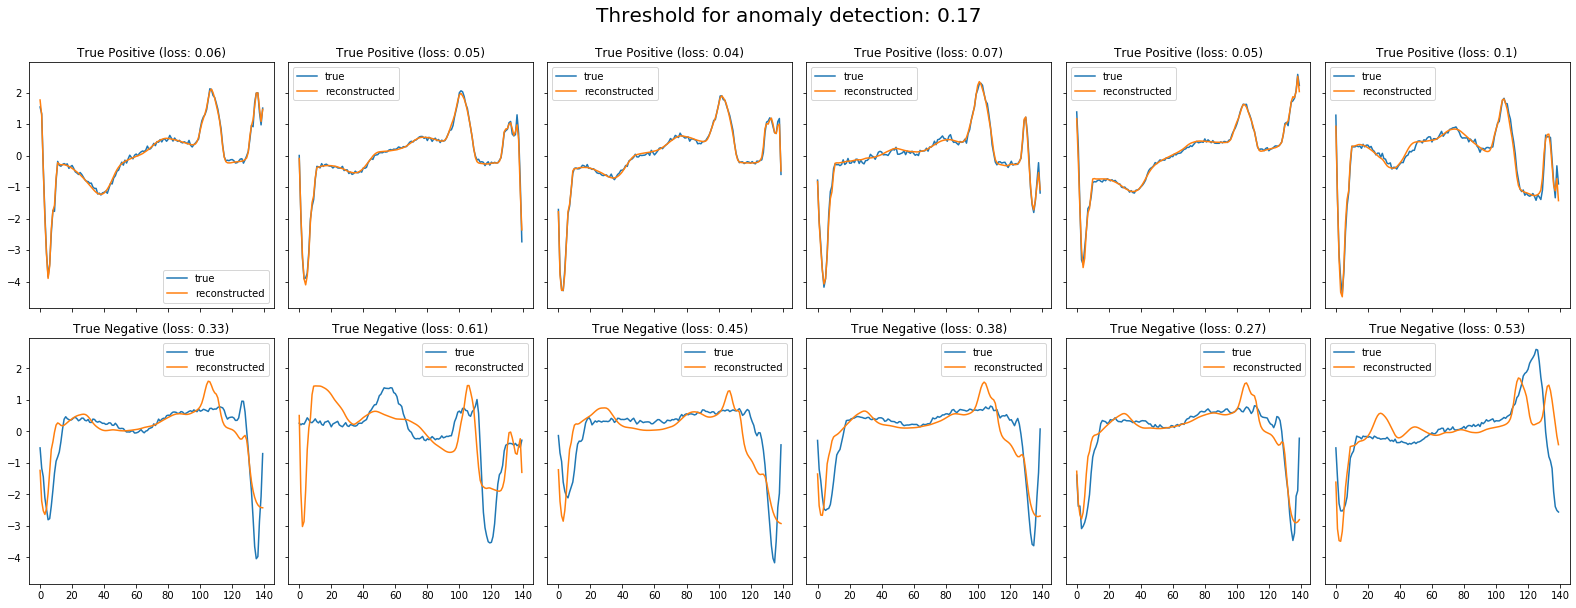

In [37]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

The reconstruction sequences look very similar to the reconstruction of the single LSTM AutoEncoder

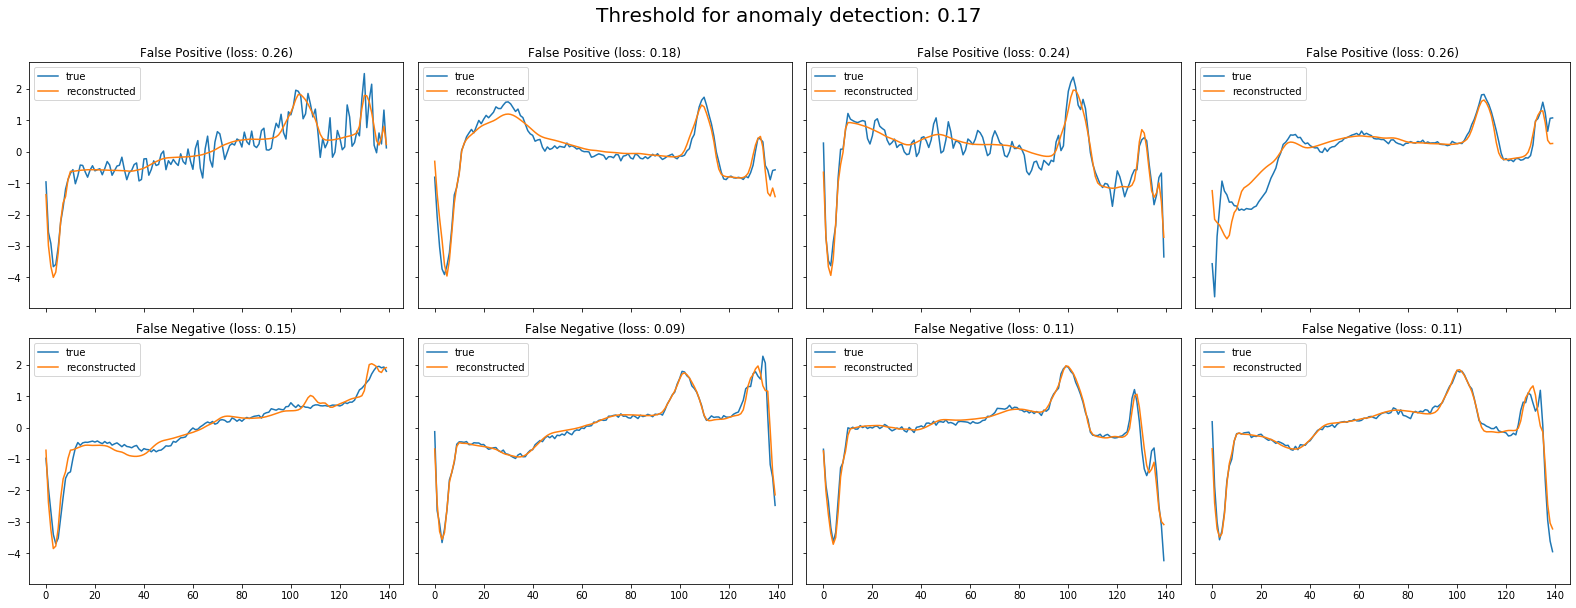

In [38]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

In [39]:
model.save('./models/Stacked_LSTM_AutoEncoder.h5')

## Show all result in one table and save it for future purpose

In [56]:
# get prediction metric result lists from placeholder
precision_score, recall_score, f1_score, accuracy_score = results.get_metrics()

# get model names list from placeholder
models_name = results.get_names()

# create dictionary of results 
results_dict = {'precision_score': precision_score, 
               'recall_score': recall_score, 
               'f1_score': f1_score,
               'accuracy_score' : accuracy_score}

results_df = pd.DataFrame(data=results_dict)
results_df.insert(loc=0, column='Model', value=models_name)
results_df

,Model,precision_score,recall_score,f1_score,accuracy_score
0,LSTM AutoEncoder,0.961734,0.968468,0.955057,0.954886
1,Stacked LSTM AutoEncoder,0.981735,0.977273,0.979499,0.989452


In [57]:
# save metrics
results_df.to_csv('./results/final_results.csv')

# save model names
with open('./results/models_name.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(models_name, f, pickle.HIGHEST_PROTOCOL)

# extract reconstructed test sequences and predictions from placeholder
test_sequences, test_predictions = results.get_test_predictions()

# save test sequences
with open('./results/test_sequences.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(test_sequences, f, pickle.HIGHEST_PROTOCOL)

# save test predictions
with open('./results/test_predictions.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(test_predictions, f, pickle.HIGHEST_PROTOCOL)